<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_2021_aug_tabular_playground_series_aug_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import scipy
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
train.shape, test.shape, submit.shape

((250000, 102), (150000, 101), (150000, 2))

In [ ]:
train['loss'].skew()  # target 라벨에 log1p씌울까 

1.4653191365369271

Text(0.5, 1.0, 'Train set Skew')

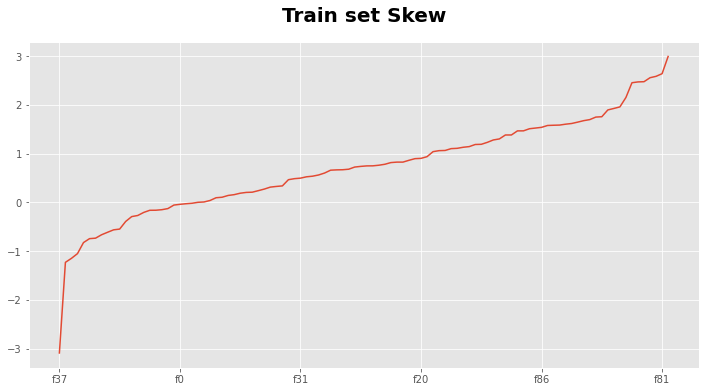

In [ ]:
plt.figure(figsize=(12,6))
train.skew().sort_values().plot()
plt.title('Train set Skew', fontsize=20, fontweight='bold', pad=20)
# noramlize를 적용 할까 고민

# cluster DBSCAN기법

- DBSCAN(density-based spatial clustering of application with noise)은 클러스터의 갯수를 미리 지정하지 않는 군집 알고리즘


- DBSCAN은 병합 군집이나 k-평균보다는 다소 느리지만 비교적 큰 데이터셋에도 적용



- 데이터의 밀집지역이 한 클러스터를 구성하며 비교적 비어있는 지역을 경계로 다른 클러스터와 구분함



- DBSCAN은 특성 공간에서 가까이 있는 데이터가 많아 붐비는 지역의 포인트를 찾음

- 이런 지역을 밀집 지역dense region이라 함

- 밀집 지역에 있는 포인트를 핵심 포인트core point라고함



- 핵심 포인트: min_samples, epsepsilon

  - 한 데이터 포인트에서 eps 거리 안에 데이터가 min_samples 갯수만큼 들어 있으면 이 데이터 포인트를 핵심 포인트로 분류

  - eps(거리)보다 가까운 핵심 샘플은 동일한 클러스터로 분류

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = pd.concat([train.drop(columns=['id']), test.drop(columns=['id'])], axis=0)
data_columns = data.columns

for i in data.columns:
  if i == 'loss':
    continue
  data[i] = MinMaxScaler().fit_transform(data[[i]])

In [ ]:
from sklearn.cluster import DBSCAN

data['cluster'] = DBSCAN(n_jobs=-1).fit_predict(data.drop(columns=['loss']))
data

KeyboardInterrupt: ignored

# Clustering 적용하자

In [3]:
!pip install catboost
!pip install optuna

     |████████████████████████████████| 67.4 MB 46 kB/s 
     |████████████████████████████████| 302 kB 4.0 MB/s 
     |████████████████████████████████| 164 kB 61.6 MB/s 
     |████████████████████████████████| 80 kB 12.4 MB/s 
     |████████████████████████████████| 75 kB 5.7 MB/s 
     |████████████████████████████████| 111 kB 74.5 MB/s 
     |████████████████████████████████| 49 kB 7.6 MB/s 
     |████████████████████████████████| 141 kB 71.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=a438d26e9feafc6a123cca8404cd4936808dd97c5604c05c3f843e69171ea96b
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
import catboost
import optuna
import optuna.integration.lightgbm as lgbo
import lightgbm
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneGroupOut, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
# 데이터 나누기
x_train = train.drop(columns=['id', 'loss'])
y_train = train['loss']
x_test = test.drop(columns=['id'])
x_train_columns = x_train.columns
x_test_columns = x_test.columns
x_train.shape, y_train.shape, x_test.shape

((250000, 100), (250000,), (150000, 100))

In [6]:
mm = MinMaxScaler().fit(x_train)
x_train = mm.transform(x_train)
x_test = mm.transform(x_test)

x_train = pd.DataFrame(x_train, columns=x_train_columns)
x_test = pd.DataFrame(x_test, columns=x_test_columns)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'elbow method')

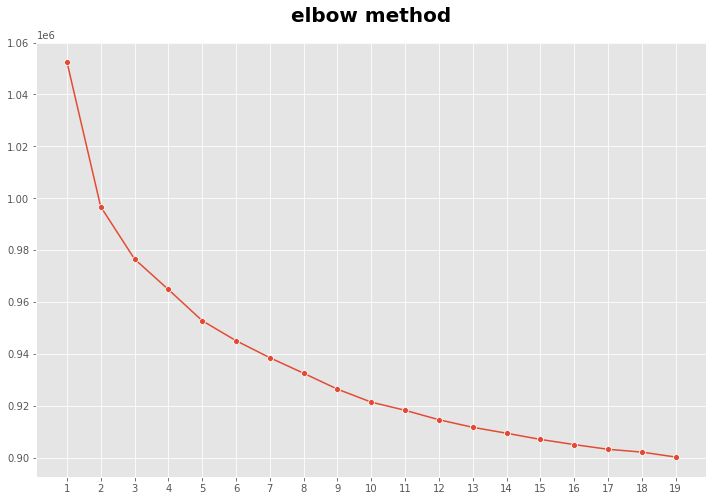

In [ ]:
# Clustering
from sklearn.cluster import KMeans

vstack = np.vstack((x_train,
                    x_test))

sse = {}
for i in range(1,20, 1):
  km = KMeans(n_clusters=i, max_iter=1000, random_state=0, n_jobs=-1).fit(vstack)
  sse[i] = km.inertia_

plt.figure(figsize=(12,8))
sns.lineplot(pd.Series(sse).index, pd.Series(sse), marker='o')
plt.xticks(pd.Series(sse).index)
plt.title('elbow method', fontsize=20, fontweight='bold', pad=20)

In [ ]:
km = KMeans(n_splits=, max_iter=1000, n_jobs=-1).fit(vstack)

x_train['cluster'] = km.predict(x_train)
x_test['cluster'] = km.predict(x_test)

In [ ]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))

for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(iterations=3000, learning_rate=0.022, loss_function='RMSE', eval_metric='RMSE', task_type='GPU')
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += np.expm1(model_cat.predict(x_test)) / kf.n_splits

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.1039045	test: 1.1063753	best: 1.1063753 (0)	total: 10.3ms	remaining: 30.9s
100:	learn: 1.0945647	test: 1.0977858	best: 1.0977858 (100)	total: 1.8s	remaining: 51.6s
200:	learn: 1.0901819	test: 1.0942911	best: 1.0942911 (200)	total: 2.91s	remaining: 40.6s
300:	learn: 1.0869794	test: 1.0920953	best: 1.0920953 (300)	total: 4.21s	remaining: 37.7s
400:	learn: 1.0843921	test: 1.0905177	best: 1.0905177 (400)	total: 5.58s	remaining: 36.2s
500:	learn: 1.0821666	test: 1.0893155	best: 1.0893155 (500)	total: 7.41s	remaining: 37s
600:	learn: 1.0800835	test: 1.0882926	best: 1.0882926 (600)	total: 9.82s	remaining: 39.2s
700:	learn: 1.0781490	test: 1.0874149	best: 1.0874149 (700)	total: 12.1s	remaining: 39.7s
800:	learn: 1.0763697	test: 1.0866818	best: 1.0866818 (800)	total: 14.4s	remaining: 39.6s
900:	learn: 1.0746677	test: 1.0860741	best: 1.0860741 (900)	total: 16.9s	remaining: 39.3s
1000:	learn: 1.0730308	test: 1.0855342	best: 1.0855342 (1000)	total: 18.9s	remaining: 37.8s
1100:	learn: 1

# LGBM LB: 7.90478

In [7]:
params = {'objective':'poisson', 'metric': 'rmse'} #'objective': 'mean_squared_error',
from sklearn.metrics import mean_absolute_error
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
lgb_train = lightgbm.Dataset(X_train, Y_train)
lgb_valid = lightgbm.Dataset(X_test, Y_test)
model = lgbo.train(params, lgb_train, valid_sets=[lgb_valid], verbose_eval=False, num_boost_round=100, early_stopping_rounds=5) 
model.params

[I 2021-08-27 05:14:16,269] A new study created in memory with name: no-name-8f42049a-75df-41ba-90c2-eba32d5db402
min_data_in_leaf, val_score: 7.871003: 100%|##########| 5/5 [01:14<00:00, 14.80s/it]


{'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'feature_fraction': 0.5,
 'feature_pre_filter': False,
 'lambda_l1': 0.0321704112910408,
 'lambda_l2': 3.6395158864107422e-06,
 'metric': 'rmse',
 'min_child_samples': 100,
 'num_leaves': 166,
 'objective': 'poisson'}

In [8]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
best_lgb_params = model.params
best_lgb_params["learning_rate"] = 0.006
best_lgb_params["num_iterations"] = 10000

for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_lgb = lightgbm.LGBMRegressor(**best_lgb_params)
  model_lgb.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=100, early_stopping_rounds=70)

  preds += model_lgb.predict(x_test) / kf.n_splits
  val_preds = model_lgb.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(val_preds, Y_valid))
  print(f'{i+1}번째 RMSE:{RMSE}')

Training until validation scores don't improve for 70 rounds.
[100]	training's rmse: 7.90686	valid_1's rmse: 7.90582
[200]	training's rmse: 7.87103	valid_1's rmse: 7.89499
[300]	training's rmse: 7.8371	valid_1's rmse: 7.88603
[400]	training's rmse: 7.80489	valid_1's rmse: 7.87885
[500]	training's rmse: 7.77367	valid_1's rmse: 7.87256
[600]	training's rmse: 7.74318	valid_1's rmse: 7.86704
[700]	training's rmse: 7.71333	valid_1's rmse: 7.86206
[800]	training's rmse: 7.68393	valid_1's rmse: 7.85749
[900]	training's rmse: 7.65496	valid_1's rmse: 7.85317
[1000]	training's rmse: 7.62636	valid_1's rmse: 7.84942
[1100]	training's rmse: 7.59815	valid_1's rmse: 7.84597
[1200]	training's rmse: 7.57041	valid_1's rmse: 7.84332
[1300]	training's rmse: 7.54287	valid_1's rmse: 7.84056
[1400]	training's rmse: 7.51564	valid_1's rmse: 7.83812
[1500]	training's rmse: 7.48863	valid_1's rmse: 7.836
[1600]	training's rmse: 7.46195	valid_1's rmse: 7.83382
[1700]	training's rmse: 7.43555	valid_1's rmse: 7.8318

# XGBoost LB: 

In [9]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 12), # Extremely prone to overfitting!
        'n_estimators': trial.suggest_int('n_estimators', 400, 4000, 400), # Extremely prone to overfitting!
        'eta': trial.suggest_float('eta', 0.007, 0.013), # Most important parameter.
        'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
        'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4), # I've had trouble with LB score until tuning this.
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4), # L2 regularization
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4), # L1 regularization
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),
        'tree_method' : 'gpu_hist',
        'booster' : 'gbtree',
        'loss_function':'rmse',
        'eval_metric':'rmse'
     }

    model = xgboost.XGBRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [10]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-27 06:17:45,936] A new study created in memory with name: no-name-22a28ed3-2b25-438f-8cdd-894a5af312d9


[06:17:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:17:51,393] Trial 0 finished with value: 7.822995181857736 and parameters: {'max_depth': 5, 'n_estimators': 2800, 'eta': 0.010257454363726017, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.7, 'min_child_weight': 79.44246795142733, 'reg_lambda': 79.89113965296997, 'reg_alpha': 371.33777018176835, 'gamma': 0.0014903811529589533}. Best is trial 0 with value: 7.822995181857736.


[06:17:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:17:54,390] Trial 1 finished with value: 7.869171982995517 and parameters: {'max_depth': 8, 'n_estimators': 2000, 'eta': 0.00989296310839738, 'subsample': 0.5, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 3.8480857583305523, 'reg_lambda': 4.023103089744351, 'reg_alpha': 0.0802206577124625, 'gamma': 1.8035496701919653}. Best is trial 0 with value: 7.822995181857736.


[06:17:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:17:59,933] Trial 2 finished with value: 7.917714787021646 and parameters: {'max_depth': 11, 'n_estimators': 2000, 'eta': 0.009870489923308768, 'subsample': 0.4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.9, 'min_child_weight': 8.356906153425442, 'reg_lambda': 0.00033356812367574777, 'reg_alpha': 0.8193148601069986, 'gamma': 969.2030679282198}. Best is trial 0 with value: 7.822995181857736.


[06:18:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:18:05,074] Trial 3 finished with value: 7.824856142561224 and parameters: {'max_depth': 6, 'n_estimators': 3200, 'eta': 0.01076404827552895, 'subsample': 0.9, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4, 'min_child_weight': 0.006541972625316709, 'reg_lambda': 0.00012140532659788163, 'reg_alpha': 514.9292222225689, 'gamma': 0.0006780756605536332}. Best is trial 0 with value: 7.822995181857736.


[06:18:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:18:11,169] Trial 4 finished with value: 7.921736706489659 and parameters: {'max_depth': 11, 'n_estimators': 1600, 'eta': 0.010706617178386831, 'subsample': 0.4, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 1.1432493980991965, 'reg_lambda': 0.005661899494881071, 'reg_alpha': 0.0035657801133438024, 'gamma': 0.0011665392802077327}. Best is trial 0 with value: 7.822995181857736.


[06:18:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:18:14,793] Trial 5 finished with value: 7.839326728365656 and parameters: {'max_depth': 11, 'n_estimators': 1600, 'eta': 0.007393528602843172, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 3566.5325058883986, 'reg_lambda': 0.09290296682465089, 'reg_alpha': 57.53493340181556, 'gamma': 8335.901227979593}. Best is trial 0 with value: 7.822995181857736.


[06:18:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:18:20,282] Trial 6 finished with value: 7.830710798371143 and parameters: {'max_depth': 8, 'n_estimators': 2800, 'eta': 0.009264893915525332, 'subsample': 0.5, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.7, 'min_child_weight': 0.00015465525451112064, 'reg_lambda': 1259.7998336831672, 'reg_alpha': 279.64239617192493, 'gamma': 0.025322715888219133}. Best is trial 0 with value: 7.822995181857736.


[06:18:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:18:29,649] Trial 7 finished with value: 7.836775217853445 and parameters: {'max_depth': 10, 'n_estimators': 1600, 'eta': 0.007184984705113374, 'subsample': 0.9, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.03246120232659389, 'reg_lambda': 235.84019000681067, 'reg_alpha': 0.7081274949873179, 'gamma': 0.018738872853340523}. Best is trial 0 with value: 7.822995181857736.


[06:18:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:18:34,240] Trial 8 finished with value: 7.842266155782956 and parameters: {'max_depth': 11, 'n_estimators': 2000, 'eta': 0.010349591370848397, 'subsample': 0.4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.4, 'min_child_weight': 2703.549281072901, 'reg_lambda': 0.003609067009752872, 'reg_alpha': 0.014286884013887743, 'gamma': 0.001958164633026899}. Best is trial 0 with value: 7.822995181857736.


[06:18:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:18:36,501] Trial 9 finished with value: 7.860054959534479 and parameters: {'max_depth': 6, 'n_estimators': 1600, 'eta': 0.007108715622777459, 'subsample': 0.4, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8, 'min_child_weight': 0.021889158629335298, 'reg_lambda': 0.0003734087904195922, 'reg_alpha': 0.0742367643677423, 'gamma': 312.84191887444814}. Best is trial 0 with value: 7.822995181857736.


[06:18:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:18:38,929] Trial 10 finished with value: 7.882726621009258 and parameters: {'max_depth': 4, 'n_estimators': 400, 'eta': 0.012968724579562581, 'subsample': 0.7, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.2, 'min_child_weight': 127.52331073922204, 'reg_lambda': 59.48740904131107, 'reg_alpha': 9177.757480462706, 'gamma': 2.168322591719527}. Best is trial 0 with value: 7.822995181857736.


[06:18:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:18:46,295] Trial 11 finished with value: 7.820646039412773 and parameters: {'max_depth': 5, 'n_estimators': 4000, 'eta': 0.011687391929520221, 'subsample': 0.9, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.5, 'min_child_weight': 0.006705479942988573, 'reg_lambda': 8340.71488692802, 'reg_alpha': 80.10481921388234, 'gamma': 0.00010338765790764442}. Best is trial 11 with value: 7.820646039412773.


[06:18:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:18:54,378] Trial 12 finished with value: 7.819564281258581 and parameters: {'max_depth': 4, 'n_estimators': 4000, 'eta': 0.012191564060148704, 'subsample': 0.8, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7, 'min_child_weight': 61.224962373430174, 'reg_lambda': 9794.515550803351, 'reg_alpha': 30.102042843273786, 'gamma': 0.0001516870492668613}. Best is trial 12 with value: 7.819564281258581.


[06:18:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:19:00,896] Trial 13 finished with value: 7.8215482940577115 and parameters: {'max_depth': 4, 'n_estimators': 4000, 'eta': 0.012390801586326532, 'subsample': 0.7, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'min_child_weight': 0.00013186344730063514, 'reg_lambda': 6780.908573989036, 'reg_alpha': 13.237173930802046, 'gamma': 0.00013620179209044225}. Best is trial 12 with value: 7.819564281258581.


[06:19:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:19:09,703] Trial 14 finished with value: 7.821484714947427 and parameters: {'max_depth': 6, 'n_estimators': 4000, 'eta': 0.011791374963611994, 'subsample': 0.8, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7, 'min_child_weight': 0.2116166730570917, 'reg_lambda': 8184.8831422627645, 'reg_alpha': 13.976389277634437, 'gamma': 0.05783185812543125}. Best is trial 12 with value: 7.819564281258581.


[06:19:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:19:21,800] Trial 15 finished with value: 7.840828316058615 and parameters: {'max_depth': 5, 'n_estimators': 3600, 'eta': 0.011504770773224171, 'subsample': 0.2, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.9, 'min_child_weight': 0.001960248801551627, 'reg_lambda': 12.369370315744323, 'reg_alpha': 4047.8239040045823, 'gamma': 0.00010531705359648876}. Best is trial 12 with value: 7.819564281258581.


[06:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:19:25,973] Trial 16 finished with value: 7.826830089369728 and parameters: {'max_depth': 7, 'n_estimators': 3200, 'eta': 0.01196076977270623, 'subsample': 0.8, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'min_child_weight': 49.14068958246151, 'reg_lambda': 785.6114290188492, 'reg_alpha': 0.00047360806955099586, 'gamma': 0.18721758426813442}. Best is trial 12 with value: 7.819564281258581.


[06:19:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:19:29,529] Trial 17 finished with value: 7.828648512725572 and parameters: {'max_depth': 4, 'n_estimators': 4000, 'eta': 0.012847340166814193, 'subsample': 0.9, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.8, 'min_child_weight': 0.2670425268227673, 'reg_lambda': 0.19230449281447382, 'reg_alpha': 4.7866679349036865, 'gamma': 15.08101966026828}. Best is trial 12 with value: 7.819564281258581.


[06:19:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:19:34,461] Trial 18 finished with value: 7.827866516564308 and parameters: {'max_depth': 9, 'n_estimators': 800, 'eta': 0.011356007170646923, 'subsample': 0.7, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 595.5580252203221, 'reg_lambda': 1372.6152307305078, 'reg_alpha': 70.33249593914327, 'gamma': 0.00668240425998368}. Best is trial 12 with value: 7.819564281258581.


[06:19:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:19:41,551] Trial 19 finished with value: 7.827407009511376 and parameters: {'max_depth': 5, 'n_estimators': 3600, 'eta': 0.009168406781890454, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.5, 'min_child_weight': 0.0010994661192192557, 'reg_lambda': 1.206475773935432, 'reg_alpha': 1777.973545325471, 'gamma': 0.20517008166919717}. Best is trial 12 with value: 7.819564281258581.


[06:19:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:19:45,633] Trial 20 finished with value: 7.840999119341005 and parameters: {'max_depth': 7, 'n_estimators': 2800, 'eta': 0.008225560963735331, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.8, 'min_child_weight': 11.335803597093786, 'reg_lambda': 18.432157922677945, 'reg_alpha': 1.9867305190210147, 'gamma': 17.67433075418665}. Best is trial 12 with value: 7.819564281258581.


[06:19:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:19:51,997] Trial 21 finished with value: 7.820523888336744 and parameters: {'max_depth': 6, 'n_estimators': 4000, 'eta': 0.011923502068760727, 'subsample': 0.8, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7, 'min_child_weight': 0.19445183226032922, 'reg_lambda': 6569.214302664558, 'reg_alpha': 45.666907802848236, 'gamma': 0.00018398149079063822}. Best is trial 12 with value: 7.819564281258581.


[06:19:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:19:59,688] Trial 22 finished with value: 7.820097769358295 and parameters: {'max_depth': 5, 'n_estimators': 3600, 'eta': 0.012217978956529842, 'subsample': 0.9, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7, 'min_child_weight': 0.31376594526411766, 'reg_lambda': 8016.241924628546, 'reg_alpha': 33.265565897181304, 'gamma': 0.0002831234228404807}. Best is trial 12 with value: 7.819564281258581.


[06:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:20:04,839] Trial 23 finished with value: 7.829697835741625 and parameters: {'max_depth': 7, 'n_estimators': 3600, 'eta': 0.012334994152029568, 'subsample': 0.7, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'min_child_weight': 0.21361933348911888, 'reg_lambda': 862.9434666087099, 'reg_alpha': 12.77255703417477, 'gamma': 0.0005562572120632655}. Best is trial 12 with value: 7.819564281258581.


[06:20:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:20:08,586] Trial 24 finished with value: 7.823310158971838 and parameters: {'max_depth': 4, 'n_estimators': 3200, 'eta': 0.011092684697919797, 'subsample': 0.8, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.8, 'min_child_weight': 1.745310675723779, 'reg_lambda': 217.53199219092667, 'reg_alpha': 0.34134720093165044, 'gamma': 0.007499920014164896}. Best is trial 12 with value: 7.819564281258581.


[06:20:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:20:14,816] Trial 25 finished with value: 7.819455489249708 and parameters: {'max_depth': 6, 'n_estimators': 3600, 'eta': 0.012433205843467573, 'subsample': 0.9, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.7, 'min_child_weight': 0.10928199331558457, 'reg_lambda': 2450.335292978793, 'reg_alpha': 43.79806734963489, 'gamma': 0.00034115404035470475}. Best is trial 25 with value: 7.819455489249708.


[06:20:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:20:23,245] Trial 26 finished with value: 7.820087951951714 and parameters: {'max_depth': 5, 'n_estimators': 3600, 'eta': 0.01247173941560965, 'subsample': 0.9, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.05026338112392708, 'reg_lambda': 2241.6370983901497, 'reg_alpha': 1146.6984548693188, 'gamma': 0.004865360293559751}. Best is trial 25 with value: 7.819455489249708.


[06:20:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:20:30,951] Trial 27 finished with value: 7.820576656978476 and parameters: {'max_depth': 4, 'n_estimators': 2400, 'eta': 0.012611402459863667, 'subsample': 0.9, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 20.54873782842239, 'reg_lambda': 286.4390766220572, 'reg_alpha': 1191.5401554972843, 'gamma': 0.004197580899332069}. Best is trial 25 with value: 7.819455489249708.


[06:20:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:20:35,827] Trial 28 finished with value: 7.838845686690238 and parameters: {'max_depth': 6, 'n_estimators': 3200, 'eta': 0.01109673829639313, 'subsample': 0.2, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.046178474059540384, 'reg_lambda': 1586.8884174301843, 'reg_alpha': 213.8431649852835, 'gamma': 0.14217808079833827}. Best is trial 25 with value: 7.819455489249708.


[06:20:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:20:40,716] Trial 29 finished with value: 7.823687980848606 and parameters: {'max_depth': 5, 'n_estimators': 2800, 'eta': 0.012619110782844153, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.8, 'min_child_weight': 291.73808407477514, 'reg_lambda': 61.14072961156055, 'reg_alpha': 796.1011992640032, 'gamma': 0.0018654747530549582}. Best is trial 25 with value: 7.819455489249708.


[06:20:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:20:46,027] Trial 30 finished with value: 7.827722034347791 and parameters: {'max_depth': 7, 'n_estimators': 3600, 'eta': 0.012219790797958551, 'subsample': 0.9, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.9, 'min_child_weight': 2.5086674930321307, 'reg_lambda': 23.863075684498824, 'reg_alpha': 218.6522461693234, 'gamma': 0.0008548396771062659}. Best is trial 25 with value: 7.819455489249708.


[06:20:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:20:51,512] Trial 31 finished with value: 7.82063929965117 and parameters: {'max_depth': 5, 'n_estimators': 3600, 'eta': 0.012111397961025679, 'subsample': 0.9, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.7, 'min_child_weight': 0.5234727029605653, 'reg_lambda': 2744.5979507413585, 'reg_alpha': 2.88307007411861, 'gamma': 0.0003772858611438302}. Best is trial 25 with value: 7.819455489249708.


[06:20:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:20:55,145] Trial 32 finished with value: 7.8221279037705385 and parameters: {'max_depth': 5, 'n_estimators': 3600, 'eta': 0.01299624457352823, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.7, 'min_child_weight': 0.07212488809833366, 'reg_lambda': 323.01777528715104, 'reg_alpha': 11.879053127672943, 'gamma': 0.0003630545107240048}. Best is trial 25 with value: 7.819455489249708.


[06:20:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:21:05,743] Trial 33 finished with value: 7.821384665999402 and parameters: {'max_depth': 4, 'n_estimators': 3200, 'eta': 0.012461697016798338, 'subsample': 0.9, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.007779992877672435, 'reg_lambda': 2728.2626080482937, 'reg_alpha': 2071.341477155116, 'gamma': 0.0032245785971466525}. Best is trial 25 with value: 7.819455489249708.


[06:21:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:21:09,913] Trial 34 finished with value: 7.825768370396082 and parameters: {'max_depth': 6, 'n_estimators': 2400, 'eta': 0.0112198223087365, 'subsample': 0.9, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.8, 'min_child_weight': 3.662631085976451, 'reg_lambda': 388.3226509122526, 'reg_alpha': 35.720027929155414, 'gamma': 0.011259074241155858}. Best is trial 25 with value: 7.819455489249708.


[06:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:21:14,612] Trial 35 finished with value: 7.819824552818989 and parameters: {'max_depth': 5, 'n_estimators': 4000, 'eta': 0.01043051411118557, 'subsample': 0.8, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.7, 'min_child_weight': 0.07200640533720953, 'reg_lambda': 3207.5425610514794, 'reg_alpha': 148.3358810487326, 'gamma': 0.00033228590911746234}. Best is trial 25 with value: 7.819455489249708.


[06:21:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:21:23,243] Trial 36 finished with value: 7.874289632464853 and parameters: {'max_depth': 12, 'n_estimators': 4000, 'eta': 0.009483127111679635, 'subsample': 0.7, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.07620761009358921, 'reg_lambda': 3.886344408230055, 'reg_alpha': 142.03408162579282, 'gamma': 0.0011366826668424697}. Best is trial 25 with value: 7.819455489249708.


[06:21:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:21:28,778] Trial 37 finished with value: 7.825324642974253 and parameters: {'max_depth': 6, 'n_estimators': 4000, 'eta': 0.010752413869381531, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.7, 'min_child_weight': 0.014109784304550154, 'reg_lambda': 2788.156056312265, 'reg_alpha': 475.5087793831686, 'gamma': 0.04416264074460016}. Best is trial 25 with value: 7.819455489249708.


[06:21:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:21:34,586] Trial 38 finished with value: 7.82982030317105 and parameters: {'max_depth': 9, 'n_estimators': 3200, 'eta': 0.01022304376963558, 'subsample': 0.8, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.0024470178612234915, 'reg_lambda': 109.15194064963046, 'reg_alpha': 525.0447066206824, 'gamma': 0.0006606776305259646}. Best is trial 25 with value: 7.819455489249708.


[06:21:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:21:39,376] Trial 39 finished with value: 7.900088264934481 and parameters: {'max_depth': 4, 'n_estimators': 1200, 'eta': 0.008513299878787628, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.4, 'min_child_weight': 0.000590923438791873, 'reg_lambda': 649.9059554017124, 'reg_alpha': 8448.925094732378, 'gamma': 0.0021068706372799656}. Best is trial 25 with value: 7.819455489249708.


[06:21:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:21:42,451] Trial 40 finished with value: 7.874747577007732 and parameters: {'max_depth': 8, 'n_estimators': 2800, 'eta': 0.009727298669664815, 'subsample': 0.5, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.7, 'min_child_weight': 0.7763110212079374, 'reg_lambda': 0.04893729925614619, 'reg_alpha': 0.5468022834796059, 'gamma': 1.0621167735151111}. Best is trial 25 with value: 7.819455489249708.


[06:21:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:21:47,067] Trial 41 finished with value: 7.8195281220642965 and parameters: {'max_depth': 5, 'n_estimators': 3600, 'eta': 0.011742197540015743, 'subsample': 0.9, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.7, 'min_child_weight': 0.6934187283235689, 'reg_lambda': 2253.4215493763722, 'reg_alpha': 26.677731794110155, 'gamma': 0.0002898096753115563}. Best is trial 25 with value: 7.819455489249708.


[06:21:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:21:53,006] Trial 42 finished with value: 7.8159370239969705 and parameters: {'max_depth': 5, 'n_estimators': 3600, 'eta': 0.012659261258244162, 'subsample': 0.9, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.8, 'min_child_weight': 0.11944816021766033, 'reg_lambda': 3783.670425468591, 'reg_alpha': 7.484196531020859, 'gamma': 0.0003743238901102269}. Best is trial 42 with value: 7.8159370239969705.


[06:21:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:21:58,024] Trial 43 finished with value: 7.8212368377091375 and parameters: {'max_depth': 5, 'n_estimators': 4000, 'eta': 0.011609836678232162, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.9, 'min_child_weight': 6.701800021808647, 'reg_lambda': 3630.8182428864156, 'reg_alpha': 4.805022106209243, 'gamma': 0.00026321263638722246}. Best is trial 42 with value: 7.8159370239969705.


[06:21:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:22:04,434] Trial 44 finished with value: 7.824750129987987 and parameters: {'max_depth': 4, 'n_estimators': 3600, 'eta': 0.01271967606195058, 'subsample': 0.9, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.8, 'min_child_weight': 7896.28018360005, 'reg_lambda': 115.6055738847958, 'reg_alpha': 0.23072493058236335, 'gamma': 0.0010436701583629317}. Best is trial 42 with value: 7.8159370239969705.


[06:22:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:22:08,160] Trial 45 finished with value: 7.827895354824651 and parameters: {'max_depth': 6, 'n_estimators': 3200, 'eta': 0.010851723631891234, 'subsample': 0.7, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.8, 'min_child_weight': 1.0489868962263207, 'reg_lambda': 635.5506845405639, 'reg_alpha': 1.8819258522116324, 'gamma': 0.0002542679119473788}. Best is trial 42 with value: 7.8159370239969705.


[06:22:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:22:13,952] Trial 46 finished with value: 7.820854687372097 and parameters: {'max_depth': 5, 'n_estimators': 4000, 'eta': 0.01190857062770757, 'subsample': 0.8, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7, 'min_child_weight': 0.12211464464781065, 'reg_lambda': 4023.5729688856713, 'reg_alpha': 22.338217793840077, 'gamma': 0.00010704855272727642}. Best is trial 42 with value: 7.8159370239969705.


[06:22:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:22:19,107] Trial 47 finished with value: 7.822861226086792 and parameters: {'max_depth': 6, 'n_estimators': 4000, 'eta': 0.010442617797195571, 'subsample': 0.8, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.8, 'min_child_weight': 0.02107673094469288, 'reg_lambda': 1356.9179841082553, 'reg_alpha': 5.398307343440428, 'gamma': 3281.5288121632852}. Best is trial 42 with value: 7.8159370239969705.


[06:22:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:22:22,521] Trial 48 finished with value: 7.825457663709553 and parameters: {'max_depth': 4, 'n_estimators': 3600, 'eta': 0.011542773172748237, 'subsample': 0.9, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'min_child_weight': 33.96965617190109, 'reg_lambda': 0.0027926710355954173, 'reg_alpha': 97.67518022377311, 'gamma': 0.0005794689998619857}. Best is trial 42 with value: 7.8159370239969705.


[06:22:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-27 06:22:35,525] Trial 49 finished with value: 7.823311688203302 and parameters: {'max_depth': 7, 'n_estimators': 3200, 'eta': 0.012102435749864485, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.2, 'min_child_weight': 0.5339009512545206, 'reg_lambda': 9766.09741461048, 'reg_alpha': 0.031843959233704734, 'gamma': 0.020990447504812795}. Best is trial 42 with value: 7.8159370239969705.


Number of finished trials: 50
Best trial: score 7.8159370239969705, params {'max_depth': 5, 'n_estimators': 3600, 'eta': 0.012659261258244162, 'subsample': 0.9, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.8, 'min_child_weight': 0.11944816021766033, 'reg_lambda': 3783.670425468591, 'reg_alpha': 7.484196531020859, 'gamma': 0.0003743238901102269}


In [11]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
params_xgb = {'booster' : 'gbtree',
              'tree_method' : 'gpu_hist',
              'loss_function':'rmse',
              'eval_metric':'rmse',
              'max_depth': study.best_params['max_depth'],
              'n_estimators': study.best_params['n_estimators'],
              'eta': study.best_params['eta'],
              'colsample_bytree': study.best_params['colsample_bytree'],
              'colsample_bylevel': study.best_params['colsample_bylevel'],
              'min_child_weight': study.best_params['min_child_weight'],
              'reg_lambda': study.best_params['reg_lambda'],
              'reg_alpha': study.best_params['reg_alpha'],
              'gamma': study.best_params['gamma'],
              'subsample': study.best_params['subsample']
          }

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_xgb = xgboost.XGBRegressor(**params_xgb)
  model_xgb.fit(X_train, Y_train, eval_set=((X_train, Y_train), (X_valid, Y_valid)), verbose=100, early_stopping_rounds=70)

  preds += model_xgb.predict(x_test) / sk.n_splits
  val_preds = model_xgb.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(Y_valid, val_preds))
  print(f'{i+1}번째 RMSE:{RMSE}')

[06:22:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:9.77114	validation_1-rmse:9.76997
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 70 rounds.
[100]	validation_0-rmse:7.83966	validation_1-rmse:7.87944
[200]	validation_0-rmse:7.78154	validation_1-rmse:7.85861
[300]	validation_0-rmse:7.73912	validation_1-rmse:7.85081
[400]	validation_0-rmse:7.7015	validation_1-rmse:7.84589
[500]	validation_0-rmse:7.66645	validation_1-rmse:7.84384
Stopping. Best iteration:
[493]	validation_0-rmse:7.66855	validation_1-rmse:7.84378

1번째 RMSE:7.843775547015061
[06:22:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:9.7706	validation_1-rmse:9.77219
Multiple eval metrics have been passed: 'validation_1-rmse' will be used fo

# Catboost LB : 7.87727

In [12]:
cat_features = x_train.select_dtypes('object').columns
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,13),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
              'objective' : 'Poisson'
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [13]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-27 06:23:15,223] A new study created in memory with name: no-name-abcf22dd-6d36-4480-94f7-4b5396fa8bbd
[I 2021-08-27 06:24:22,914] Trial 0 finished with value: 7.877257317693655 and parameters: {'iterations': 23473, 'learning_rate': 0.15949543326637927, 'reg_lambda': 78.12887130289617, 'subsample': 0.7863962060318391, 'random_strength': 47.38964481689676, 'depth': 8, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 6}. Best is trial 0 with value: 7.877257317693655.
[I 2021-08-27 06:24:27,518] Trial 1 finished with value: 7.853815095913282 and parameters: {'iterations': 13277, 'learning_rate': 0.3504692039676225, 'reg_lambda': 0.7969328871151706, 'subsample': 0.5015407914000056, 'random_strength': 24.091724244215857, 'depth': 5, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 10}. Best is trial 1 with value: 7.853815095913282.
[I 2021-08-27 06:24:35,037] Trial 2 finished with value: 8.03927838143716 and parameters: {'iterations': 10699, 'learning_rate': 0.4914715527

Number of finished trials: 50
Best trial: score 7.819812852629622, params {'iterations': 6322, 'learning_rate': 0.03369995529334409, 'reg_lambda': 82.82081066123634, 'subsample': 0.3335357108736585, 'random_strength': 25.427639293873412, 'depth': 4, 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 7}


In [14]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
params_cat = {'iterations':study.best_params['iterations'],
         'loss_function':'RMSE',
         'task_type':"GPU",
         'eval_metric':'RMSE',
         'leaf_estimation_method':'Newton',
         'bootstrap_type': 'Bernoulli',
         'learning_rate' : study.best_params['learning_rate'],
         'reg_lambda': study.best_params['reg_lambda'],
         'subsample': study.best_params['subsample'],
         'random_strength': study.best_params['random_strength'],
         'depth': study.best_params['depth'],
         'min_data_in_leaf': study.best_params['min_data_in_leaf'],
         'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
         'grow_policy' : 'Depthwise',  
}

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(**params_cat)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += model_cat.predict(x_test) / sk.n_splits
  val_preds = model_cat.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(val_preds, Y_valid))
  print(f'{i+1}번째 RMSE:{RMSE}')

0:	learn: 7.9391013	test: 7.9382054	best: 7.9382054 (0)	total: 8.65ms	remaining: 54.7s
100:	learn: 7.8922997	test: 7.9063759	best: 7.9063759 (100)	total: 698ms	remaining: 43s
200:	learn: 7.8663263	test: 7.8918360	best: 7.8918360 (200)	total: 1.43s	remaining: 43.4s
300:	learn: 7.8458550	test: 7.8809723	best: 7.8809723 (300)	total: 2.17s	remaining: 43.5s
400:	learn: 7.8286385	test: 7.8737599	best: 7.8737599 (400)	total: 2.92s	remaining: 43.1s
500:	learn: 7.8138924	test: 7.8679556	best: 7.8679556 (500)	total: 3.66s	remaining: 42.5s
600:	learn: 7.8004974	test: 7.8634601	best: 7.8634601 (600)	total: 4.4s	remaining: 41.9s
700:	learn: 7.7880803	test: 7.8600910	best: 7.8600910 (700)	total: 5.14s	remaining: 41.2s
800:	learn: 7.7762687	test: 7.8567792	best: 7.8567792 (800)	total: 5.88s	remaining: 40.5s
900:	learn: 7.7655090	test: 7.8550115	best: 7.8549841 (896)	total: 6.61s	remaining: 39.8s
1000:	learn: 7.7551696	test: 7.8532793	best: 7.8532764 (999)	total: 7.35s	remaining: 39.1s
1100:	learn: 7.

# voting regressor

In [15]:
from sklearn.ensemble import VotingRegressor

In [16]:
cat = catboost.CatBoostRegressor(**params_cat)
lgb = lightgbm.LGBMRegressor(**best_lgb_params)
xgb = xgboost.XGBRegressor(**params_xgb)

In [ ]:
from sklearn.ensemble import VotingRegressor
folds = KFold(n_splits = 10, random_state = 42, shuffle = True)

predictions = np.zeros((len(x_test),))

for fold, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    print(f"Fold: {fold}")
    X_train, X_val = x_train.values[trn_idx], x_train.values[val_idx]
    Y_train, Y_val = y_train.values[trn_idx], y_train.values[val_idx]

    model = VotingRegressor(
            estimators = [
                ('xgb', xgb),
                ('cat', cat),
                ('lgb', lgb)
            ],
            weights = [0.25, 0.5, 0.25]
        )
   
    model.fit(X_train, Y_train)
    pred = model.predict(X_val)
    error = mean_squared_error(Y_val, pred,squared = False)
    print(f" mean_squared_error: {error}")
    print("-"*50)
    
    predictions += model.predict(x_test) / folds.n_splits 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
7183:	learn: 7.7301637	total: 42.7s	remaining: 29.7s
7184:	learn: 7.7301482	total: 42.7s	remaining: 29.7s
7185:	learn: 7.7301358	total: 42.7s	remaining: 29.7s
7186:	learn: 7.7301134	total: 42.7s	remaining: 29.7s
7187:	learn: 7.7301010	total: 42.7s	remaining: 29.7s
7188:	learn: 7.7300898	total: 42.7s	remaining: 29.7s
7189:	learn: 7.7300717	total: 42.8s	remaining: 29.7s
7190:	learn: 7.7300381	total: 42.8s	remaining: 29.7s
7191:	learn: 7.7300286	total: 42.8s	remaining: 29.7s
7192:	learn: 7.7300122	total: 42.8s	remaining: 29.7s
7193:	learn: 7.7300016	total: 42.8s	remaining: 29.7s
7194:	learn: 7.7299800	total: 42.8s	remaining: 29.6s
7195:	learn: 7.7299564	total: 42.8s	remaining: 29.6s
7196:	learn: 7.7299415	total: 42.8s	remaining: 29.6s
7197:	learn: 7.7299375	total: 42.8s	remaining: 29.6s
7198:	learn: 7.7299274	total: 42.8s	remaining: 29.6s
7199:	learn: 7.7299176	total: 42.8s	remaining: 29.6s
7200:	learn: 7.7299076	total: 42.8s	remaining: 29.6s
7201:	lear

# Stacking Regressor

In [ ]:
cat = catboost.CatBoostRegressor(**params_cat)
lgb = lightgbm.LGBMRegressor(**best_lgb_params)
xgb = xgboost.XGBRegressor(**params_xgb)

In [17]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression

folds = KFold(n_splits = 10, random_state = 2021, shuffle = True)

predictions = np.zeros((len(x_test),))

for fold, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    print(f"Fold: {fold}")
    X_train, X_val = x_train.values[trn_idx], x_train.values[val_idx]
    Y_train, Y_val = y_train.values[trn_idx], y_train.values[val_idx]

    model = StackingRegressor(
            estimators = [
                ('xgb', xgb),
                ('cat', cat),
                ('lgb', lgb)
            ],
            final_estimator=LinearRegression()
        )
   
    model.fit(X_train, Y_train)
    pred = model.predict(X_val)
    error = mean_squared_error(Y_val, pred,squared = False)
    print(f" mean_squared_error: {error}")
    print("-"*50)
    
    predictions += model.predict(x_test) / folds.n_splits 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1322:	learn: 7.7011114	total: 10.1s	remaining: 38.3s
1323:	learn: 7.7010212	total: 10.2s	remaining: 38.3s
1324:	learn: 7.7009123	total: 10.2s	remaining: 38.3s
1325:	learn: 7.7008290	total: 10.2s	remaining: 38.3s
1326:	learn: 7.7007521	total: 10.2s	remaining: 38.3s
1327:	learn: 7.7006468	total: 10.2s	remaining: 38.3s
1328:	learn: 7.7005393	total: 10.2s	remaining: 38.3s
1329:	learn: 7.7004592	total: 10.2s	remaining: 38.3s
1330:	learn: 7.7003781	total: 10.2s	remaining: 38.3s
1331:	learn: 7.7002496	total: 10.2s	remaining: 38.3s
1332:	learn: 7.7001075	total: 10.2s	remaining: 38.2s
1333:	learn: 7.6999841	total: 10.2s	remaining: 38.2s
1334:	learn: 7.6998936	total: 10.2s	remaining: 38.3s
1335:	learn: 7.6997778	total: 10.2s	remaining: 38.2s
1336:	learn: 7.6996905	total: 10.3s	remaining: 38.2s
1337:	learn: 7.6995855	total: 10.3s	remaining: 38.2s
1338:	learn: 7.6994776	total: 10.3s	remaining: 38.2s
1339:	learn: 7.6993990	total: 10.3s	remaining: 38.2s
1340:	lear

KeyboardInterrupt: ignored

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
submit['loss'] = predictions
submit

,id,loss
0,250000,8.465962
1,250001,4.385302
2,250002,8.648569
3,250003,7.194910
4,250004,6.851920
...,...,...
149995,399995,8.057907
149996,399996,7.580662
149997,399997,5.886419
149998,399998,5.054294


In [ ]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/submit12.csv', index=False)

# To Do
* optuna integration 사용 해보기
* 다른 모델 사용(Rasso, Ridge, ElasticNet)